In [2]:
import pandas as pd
import numpy as np
from scipy.misc import logsumexp
from scipy.optimize import minimize


labels = ['IND', 'GLO', 'CLU', 'SDH']
df = pd.read_csv('../data/pilot_1.csv', dtype={
    'IND': float,
    'GLO': float,
    'CLU_012': float,
    'CLU_120': float,
    'CLU_201': float,
    'SDH_012': float,
    'SDH_120': float,
    'SDH_201': float,
})
df['CLU'] = df[['CLU_012', 'CLU_120', 'CLU_201']].apply(logsumexp, axis=1)
df['SDH'] = df[['SDH_012', 'SDH_120', 'SDH_201']].apply(logsumexp, axis=1)
df = df[labels + [
    'Kalman_choice',
    'ground_truth',
    'Johannes_choice',
    'Johannes_confidence',
    'Sichao_choice',
    'Sichao_confidence'
]]
df.iloc[:, :4] = df.iloc[:, :4].subtract(df.iloc[:, :4].max(axis=1), axis=0)
target = 'Johannes_choice'
count = df[target].value_counts()[labels].to_numpy()

In [39]:
def loss_fun(𝜃):
    global step
    u = df.iloc[:, :4].copy()
    u.iloc[:, 1:4] = u.iloc[:, 1:] + 𝜃[1:]
    βu = u * 𝜃[0]
    normalizer = βu.apply(logsumexp, axis=1)
    ℓ = βu.apply(lambda row: row[df[target][row.name]], axis=1)
    loss = (normalizer - ℓ).sum()
    return loss

In [67]:
import matplotlib.pyplot as plt
def plot_loss(f, x, y):
    z = []
    for i in y:
        zi = []
        for j in x:
            zi.append(f(j, i))
        z.append(zi)
    z = np.array(z)
    x, y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(45, -45)
    ax.plot_surface(x, y, z, cmap='terrain')
    return ax

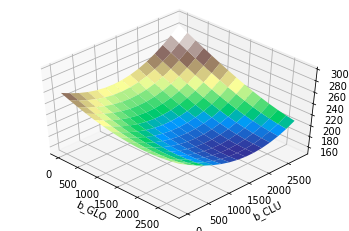

In [87]:
ax = plot_loss(lambda j, i: loss_fun(np.array([0.001, j, i, 1000])),
               np.arange(0, 3000, 200), 
               np.arange(0, 3000, 200))
ax.set_zlim3d(150, 300)
ax.set_xlabel('b_GLO')
ax.set_ylabel('b_CLU')
plt.show()

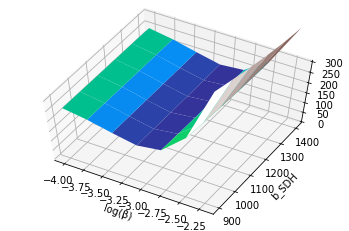

In [91]:
ax = plot_loss(lambda j, i: loss_fun(np.array([10**j, 3000, 1500, i])),
               np.arange(-4, -2, 0.3),
               np.arange(900, 1500, 100))
ax.set_zlim3d(0, 300)
ax.view_init(60, -60)
ax.set_xlabel('log(β)')
ax.set_ylabel('b_SDH')
plt.show()

In [44]:
print(loss_fun(np.array([0, 3000, 1500, 1000])))
print(loss_fun(np.array([0.1, 3000, 1500, 1000])))
print(loss_fun(np.array([0.01, 3000, 1500, 1000])))
print(loss_fun(np.array([0.001, 3000, 1500, 1000])))
print(loss_fun(np.array([0.0001, 3000, 1500, 1000])))
print(loss_fun(np.array([0.00001, 3000, 1500, 1000])))

277.2588722239781
8113.867869473248
826.6679165272291
188.02930168657082
256.17303580519774
274.9906352078207
